In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import torch.nn.functional as F

In [3]:
words = open('names.txt').read().splitlines()
len(words), words[:8]

(32033,
 ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia'])

In [4]:
# let's only have one special token, and let's have it at index 0, offset others by 1
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
num_classes = len(stoi)
vocab_size = len(itos)
print(vocab_size, itos)

27 {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
def build_dataset(words, block_size):
    X, Y, = [], [] # X, input | Y, labels

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append moving window

    X = torch.tensor(X)
    Y = torch.tensor(Y)    
    return X, Y

In [6]:
# Splits
import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

block_size = 3 # context length : How many characters do we take to predict the next one : 3 chars to predict the 4th

Xtr, Ytr = build_dataset(words[:n1], block_size)
Xva, Yva = build_dataset(words[n1:n2], block_size)
Xte, Yte = build_dataset(words[n2:], block_size)

Xtr.shape, Ytr.shape, Xva.shape, Yva.shape, Xte.shape, Yte.shape

(torch.Size([182625, 3]),
 torch.Size([182625]),
 torch.Size([22655, 3]),
 torch.Size([22655]),
 torch.Size([22866, 3]),
 torch.Size([22866]))

In [7]:
# Great to know that we have these magic number for weights and biases
# But how do I know what to set these to if I have a large NN
# OBVIOUSLY : Nobody does this by hand
# Some principled ways to do this
# Let's motivate this discussion

In [8]:
# Two values drawn from gaussion that are matmulted
# What are the mean and std. dev.
# Normal Gaussian distr : mean 0.0, std.dev. 1.0

tensor(-0.0008) tensor(1.0104)
tensor(0.0224) tensor(3.1560)


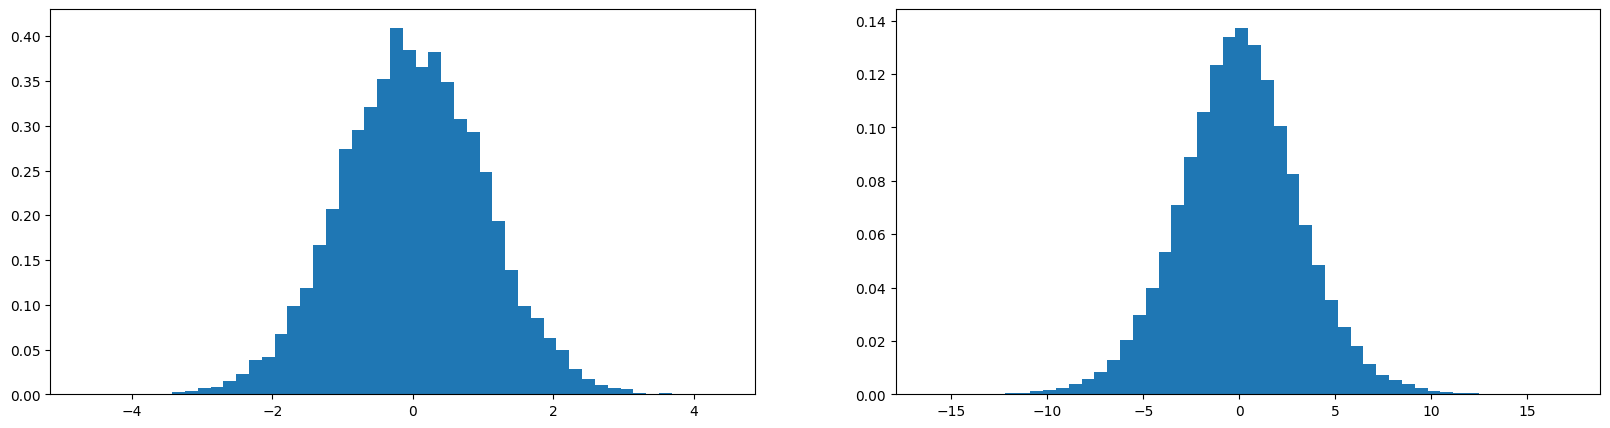

In [9]:
x = torch.randn(1000, 10)
w = torch.randn(10, 100)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [10]:
# After x @ w, we see that the mean stays at zero, but the std. dev has expanded
# the data has spreaded further out
# WE DON'T WANT THAT
# We want most of the NNs to have relatively similar activations, unit gaussian roughly throughout the NN
# So how we scale the ws in a way to preseve the distribution spread after matmul so that it remains a gaussion
# If we multiply the w by something large or something, the spread follows propotionally

tensor(0.0054) tensor(1.0029)
tensor(0.0421) tensor(15.8039)
tensor(0.0012) tensor(0.3199)


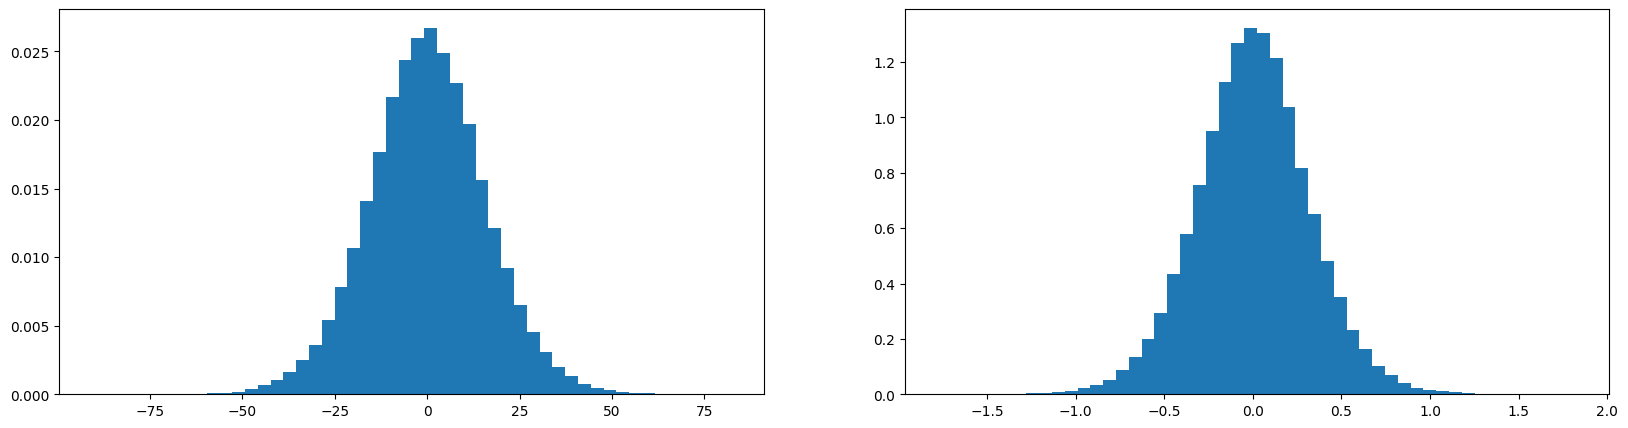

In [11]:
x = torch.randn(1000, 10)
w1 = torch.randn(10, 100) * 5
w2 = torch.randn(10, 100) * 0.1
y1 = x @ w1
y2 = x @ w2
print(x.mean(), x.std())
print(y1.mean(), y1.std())
print(y2.mean(), y2.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(y1.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y2.view(-1).tolist(), 50, density=True);

In [12]:
# What do I multiply the w so that I preserve the gaussian distribution (instead of manually picking numbers)
# The correct answer mathematically when working out through the variance of the matmulted tensor
# You divided the weights by the square root of fan in (number of input elements)

tensor(0.0045) tensor(1.0024)
tensor(0.0005) tensor(1.0101)


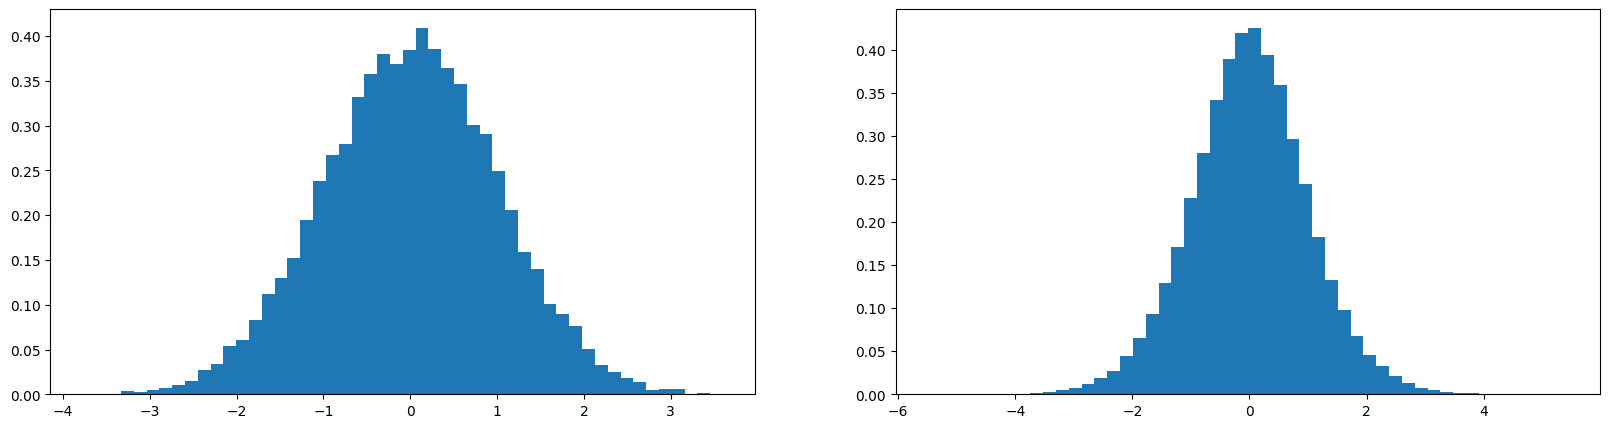

In [13]:
x = torch.randn(1000, 10)
w = torch.randn(10, 100) / 10**0.5 # the fan in is the number of elements multiplying in to the weight neuron
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [14]:
# Check out the std. deviation of the output y, it has the same characteristics of gaussian

In [15]:
# Lots of papers have looked into how to best initialise neural networks
# In case of MLP, we can have fairly deep networks with non linearities in between
# We want to make sure the activations are well behaved
# Dont expand to infinity or shrink down to zero
# So, how do we activate weights so they stay within reasonable values during the training

In [16]:
# Kaiming He paper : Delving deep into rectifiers
# study of ReLu but analysis is the same
# squashing fn where all neg numbers are clamped to zero
# you're throwing away half of the distribution, so you have compensate for that with a gain
# zero mean Gaussian distr. std dev. is sqrt(2/fan_n)
# 2 is added because of the relu since half the distr. is thrown away

# The paper also studies the backward pass (backpropagation)
# We want to make sure that the gradients are well behaved on backward pass too
# They find that if you properly initialise the forward pass,
# the backward pass is also approximately initialised up to a constant factor
# that has to do with number of neurons in early and late layers

# THE GOOD NEWS : Kaiming init is also implemented in PyTorch
# Probably the most common way of initializing neural networks these days
# arguments : mode = fan_in | fan_out 
#                    normalise the activation(forward pass) or normalise the gradients(backward pass)
#                    in the paper they find this does not matter too much, most people use defaults, fan_in
# nonlinearity : depending on the non linearity we need to calculate a slightly different gain
#                all that info is present in the pytorch modules to calculate gain
#                why do we need a gain on top of init : tanh is contractive like relu, so you need to expand it back to gaussian
#                the goal is to be able to bring the distr. back to unit std. dev

# 7 years ago when this paper was written
# you had to careful about gradients, activation, gains etc.
# everything was fragile esp. but deeper nets
# but modern innovations have made this problem non significant by making the nns more stable and well behaved
#     residual connections
#     normalization layers (batchnorm etc.)
#     much better optimizers (rmsprop, adam etc.)

# its less important to init properly these days

In [17]:
# In practice what should we do
# normalize by the weight of fan_in

In [18]:
# but if we were to use kaiming init
torch.randn(10000).std(), (torch.randn(10000)*0.2).std()

(tensor(0.9980), tensor(0.2028))

In [19]:
# for tanh, the proper gain should have been for W1
5/3 / (block_size*10)**0.5

0.3042903097250923

In [20]:
# Lets continue with this formula for the training now

In [21]:
n_embed = 10   # dimensionality of characters in the embedding vector
n_hidden = 200 # number of neurons in the hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),             generator=g)
W1 = torch.randn((block_size * n_embed, n_hidden), generator=g) * (5/3/(block_size*n_embed)**0.5)
b1 = torch.randn(n_hidden,                         generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),           generator=g) * 0.01
b2 = torch.randn(vocab_size,                       generator=g) * 0
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters) # total number of parameters

11897

In [22]:
max_steps = 200000
batch_size = 32

In [23]:
lossi = []
losslog10i = []
stepsi = []

In [24]:
tot_steps = len(stepsi)

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # forward pass
    emb = C[Xb]                         # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1          # hidden layer pre-activation
    h = torch.tanh(hpreact)             # hidden layer
    logits = h @ W2 + b2                # output layer
    loss = F.cross_entropy(logits, Yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01    # switch learning rate
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    stepsi.append(tot_steps+i)
    lossi.append(loss.item())
    losslog10i.append(loss.log10().item())
    
    # Print loss 
    if (i)%(max_steps/10) == 0:
        print(f"Loss {i}/{max_steps}: {loss.item()}")

Loss 0/200000: 3.3179006576538086
Loss 20000/200000: 2.3270041942596436
Loss 40000/200000: 1.946812391281128
Loss 60000/200000: 2.385174512863159
Loss 80000/200000: 2.3158998489379883
Loss 100000/200000: 1.8590792417526245
Loss 120000/200000: 1.938940167427063
Loss 140000/200000: 2.0949158668518066
Loss 160000/200000: 1.7824305295944214
Loss 180000/200000: 1.975154161453247


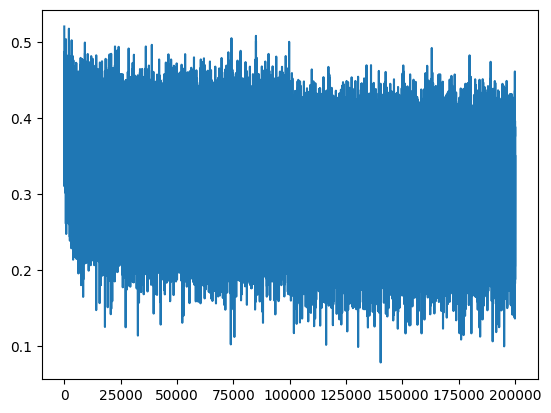

In [25]:
plt.plot(stepsi, losslog10i)

In [26]:
@torch.no_grad() # this decorator disables gradient tracking, can also the context manager instead
def split_loss(split):
    ds = {
        'train': (Xtr, Ytr),
        'val':   (Xva, Yva),
        'test':  (Xte, Yte),
    }
    x,y = ds[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(f'{split} loss : {loss.item()}')

split_loss('train')
split_loss('val')

train loss : 2.0376641750335693
val loss : 2.106989622116089


In [27]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(10):
    out = []
    block_size = 3
    context = [0] * block_size # initialize all with ...
    while True:
        # forward pass
        emb = C[torch.tensor([context])] # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1) # exponentiates the logits and then softmaxes them, similar to cross entroy no overflows
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # break if we reach the special token '.'
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

carmahzaylyn.
kiffinleige.
tyrencessa.
jazon.
nadelynn.
jareei.
nellara.
chaiivan.
legyn.
ham.


In [28]:
# Note our losses going down with tricks

# Train test validation split - in the beginning
# Train Loss : 2.2589
# Val Loss   : 2.2702

# After increasing NN capacity and embedding size
# Train Loss : 2.1190
# Val Loss   : 2.1711

# After fixing init weight bias softmax confidently wrong
# Train loss : 2.0695
# Val loss   : 2.1310

# After fixing tanh saturation
# train loss : 2.0355
# val loss   : 2.1026

# Now, with kaiming init and not using magic numbers for tanh saturation
# train loss : 2.0376
# val loss   : 2.1069

In [29]:
# We now have something semi principled, no magic numbers and that can scale us to bigger networks
# and use something as a guide